In [1]:
import os
import requests
import torch

from src.tokenizer import CharTokenizer

__file__='shakespeare_data/'

# download the tiny shakespeare dataset
input_file_path = os.path.join(os.path.dirname(__file__), 'input.txt')
if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)


#create the tokenizer
tokenizer=CharTokenizer(input_file_path)
print('tokenizer vocab size:', tokenizer.vocab_size)


length of dataset in characters: 1,115,394
tokenizer vocab size: 65


In [2]:
# load the data
with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")


# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = tokenizer(train_data)
val_ids = tokenizer(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# export to bin files
torch.save(train_ids, os.path.join(os.path.dirname(__file__), 'train.bin'))
torch.save(val_ids,   os.path.join(os.path.dirname(__file__), 'val.bin'))

length of dataset in characters: 1,115,394
train has 1,003,854 tokens
val has 111,540 tokens


In [3]:
import torch
from torch import nn
from IPython.display import clear_output

from src.encoder import Encoder, GPT2Encoder
from src.decoder import Decoder, GPT2Decoder
from src.graph_initialization import random_unidirectional_graph_maker, linear_unidirectional_graph_maker
from src.graphAN import GraphAttentionNetwork, BlockGenerator
from src.data_loader import validation
from src.tokenizer import Tokenizer
from src.GPT2 import GPT2_Block, GPT2
from matplotlib import pyplot as plt
from src.utils import moving_average, grad_norm
from torch.nn.utils import clip_grad_norm_
import pickle
import numpy as np
from termcolor import colored



In [4]:
device = 'cpu'
#device = 'mps'  if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device

dK = 32
dV = 32
heads = 4
d_Embedding = dV*heads
intermediate_size=intermediate_size=d_Embedding


encoder = Encoder(d_Embedding, tokenizer, dropout=0, device=device)
decoder = Decoder(encoder)
block_generator = BlockGenerator(GPT2_Block, d_Embedding, dK, dV, heads, intermediate_size,
                                 dropout=0.1, split_size=2**10, device=device, rotary_encoding=True)

model = GraphAttentionNetwork(tokenizer, encoder, block_generator, decoder, n_blocks=2)
model.losses = []
model.validation_losses = []
model.tokens_seen=0


#model.load('shakespeare_data/pretrained_CE=1.3.pth')

print(f'number of parameters:{model.n_parameters}')

graph_maker = linear_unidirectional_graph_maker(64, device=device)

number of parameters:213248


In [7]:
from src.decoder import Loss

loss_function = Loss(decoder)

lr = 1e-3
gamma = 0.99

grad_norms = []

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)

In [8]:
from numpy.random import randint
def sample_shakespeare(data, lenght, starting_index=None):
    lenght=int(lenght)
    
    if starting_index is None:
        starting_index = randint(0, len(data)-lenght)

    if starting_index+lenght>=len(data):
        return data[starting_index:]    
    
    return data[starting_index:starting_index+lenght]


tokens_seen:67.74%, context_size:400.0, loss:2.38
Validation loss: 2.64


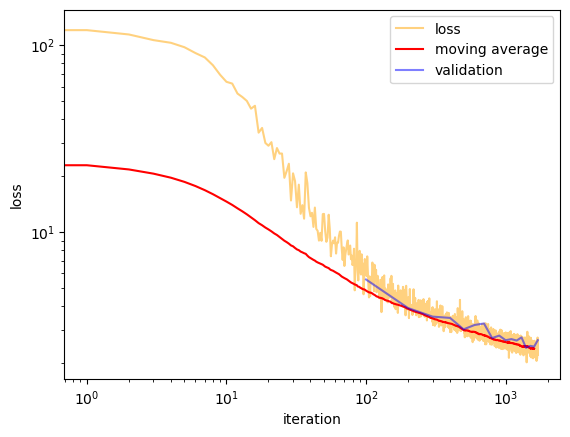

KeyboardInterrupt: 

In [9]:
#@title {vertical-output: true}
#@markdown # Training
#@markdown the loss function is cross entropy ❌🎲

n_epochs = int(2000)
model.train()
context_size=4e2
model.train()

for i in range(n_epochs):

    
    inp=sample_shakespeare(train_ids, context_size)

    nodes = inp[:-1]
    targets = inp[1:]
    edge_index = graph_maker(nodes.shape[0])
    prediction = model(nodes, edge_index)
    loss = loss_function(prediction, targets)

    model.losses.append(loss.item())
    loss.backward()

    clip_grad_norm_(model.parameters(), 4*loss.item())

    optimizer.step()
    optimizer.zero_grad()  # reinitialize the gradient to zero
    model.tokens_seen+=context_size

    if i%100==99:

        m_av = moving_average(model.losses, 99)
        model.best_loss = min(m_av)

        if model.best_loss<2.2:
            context_size=2e3

        if model.best_loss<1.8:
            context_size=5e3

        inp=sample_shakespeare(val_ids, 1e3)
        nodes=inp[:-1]
        targets=inp[1:]
        edge_index = graph_maker(nodes.shape[0])
        prediction = model(nodes, edge_index)
        validation_loss = loss_function(prediction, targets)

        model.validation_losses.append(validation_loss.item())
        
        clear_output()

        print(f'tokens_seen:{(model.tokens_seen*100/len(train_ids)):.2f}%, context_size:{context_size}, loss:{m_av[-1]:.2f}')
        print(f'Validation loss: {validation_loss:.2f}')

        plt.plot(model.losses, label='loss', color='orange', alpha=0.5)
        plt.plot(m_av, label='moving average', color='red')
        plt.plot(np.arange(len(model.validation_losses))*100+100, model.validation_losses, label='validation',color='blue',alpha=0.5)

        plt.legend()
        plt.ylabel('loss')
        plt.xlabel('iteration')
        plt.yscale('log')
        plt.xscale('log')
        plt.show()

In [24]:
model.eval()
#model.load('shakespeare_data/pretrained_CE=1.3.pth')
text=sample_shakespeare(val_data, 200)
embeddings=tokenizer(text)

targets=embeddings[1:]
embeddings=embeddings[:-1]
edge_index=graph_maker(embeddings.shape[0])

print('\n\n',loss_function(model(embeddings,edge_index),targets).item())
asd=tokenizer.decode(model.final_embedding(embeddings,edge_index).argmax(dim=-1))



print(text)



 2.237180471420288
weapon drop.

MIRANDA:
Beseech you, father.

PROSPERO:
Hence! hang not on my garments.

MIRANDA:
Sir, have pity;
I'll be his surety.

PROSPERO:
Silence! one word more
Shall make me chide thee, if not 


In [28]:
u=0
for a,b in zip(text,' '+asd):
    if a==b:
        u+=1

u/len(text)

0.415

In [26]:
n_generated=400
out=model.generate(text,n_generated,graph_maker,1)[-n_generated:]

In [27]:
print(f"{text}\x1b[31m{out}\x1b[0m")

weapon drop.

MIRANDA:
Beseech you, father.

PROSPERO:
Hence! hang not on my garments.

MIRANDA:
Sir, have pity;
I'll be his surety.

PROSPERO:
Silence! one word more
Shall make me chide thee, if not my to never him an our and or am.

ESCALUS:
WhyLond as bun't blood me same is a hows and his, his not of my
to he tirecemman's cleansuly; yes?

Clown:
Stes him eyou for rese: a to shave rew-loves in prompleks are.

QUEEN MARGARET:
Eas dear mumby? Whow, son: his him condition and didly
some agret stes pot to let is stand asburn your death, when this to is
fruet to the court a couses the raid expect


In [12]:
Q,K,V



out[n1:n2] = softmax(Q[n1:n2]•K)•V

SyntaxError: invalid character '•' (U+2022) (2476079166.py, line 5)